In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

import torch 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import os
import pickle
from sklearn.utils.class_weight import compute_class_weight

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import os
from itertools import chain

import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
# import transform_fns as trans
import pdm_functions as fns
import process_fns as pfns
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from scipy.stats import gaussian_kde

import pickle


In [2]:
print(os.getcwd())

C:\SK\ai_proj\data_analysis\final_experiment


In [3]:
model = torch.load('datasets/1005)stacked_model(dev-0.9705).pth')

C:\Users\user\AppData\Local\Temp\ipykernel_12540\3883039201.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('datasets/1005)stacked_model(dev-0.9705).p

In [4]:
data = torch.load('datasets/spec_datasets.pt',  weights_only=True)

In [5]:
file_path='datasets/5520_spectrum_x_weights.pkl'
with open(file_path, 'rb') as f: 
    wf_x = torch.tensor(pickle.load(f))
    
file_path='datasets/5520_spectrum_y_weights.pkl'
with open(file_path, 'rb') as f: 
    wf_y = torch.tensor(pickle.load(f))
    
file_path='datasets/5520_spectrum_z_weights.pkl'
with open(file_path, 'rb') as f: 
    wf_z = torch.tensor(pickle.load(f))

<Axes: >

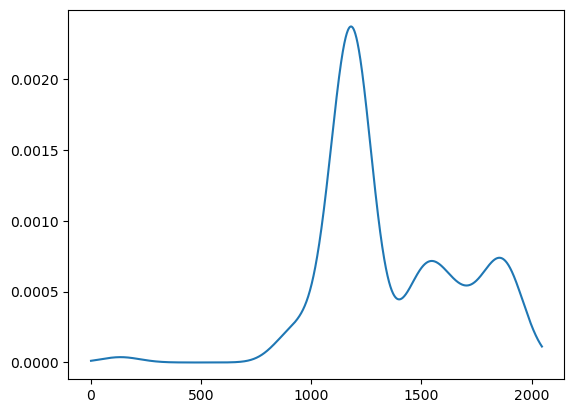

In [6]:
sns.lineplot(wf_x)

<Axes: >

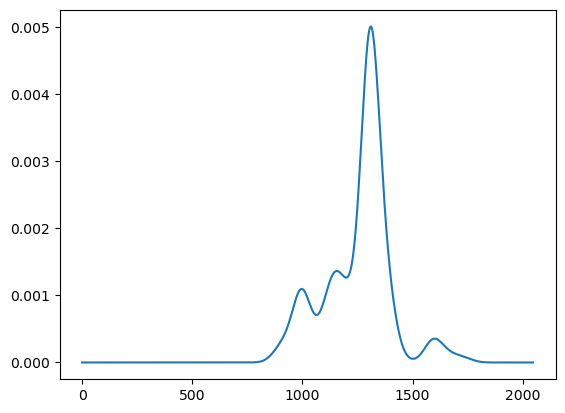

In [7]:
sns.lineplot(wf_y)

<Axes: >

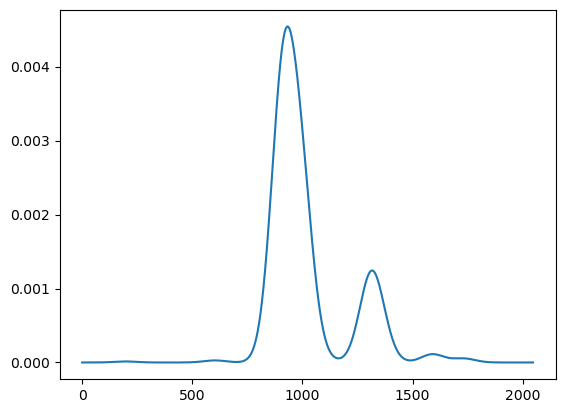

In [8]:
sns.lineplot(wf_z)

In [10]:
wf = torch.stack((wf_x, wf_y, wf_z), dim= 0)

wf = wf.repeat(12,1)

wf = wf.reshape(1, 1, 36, 2048)
wf.shape

torch.Size([1, 1, 36, 2048])

In [11]:
wf = wf * 100000

In [16]:
X_dev, y_dev = data['X_dev'], data['y_dev']
X_test, y_test = data['X_test'], data['y_test']
X_train = data['X_train']

In [9]:
X_dev.shape, y_dev.shape

(torch.Size([370, 1, 36, 2048]), torch.Size([370]))

<Axes: >

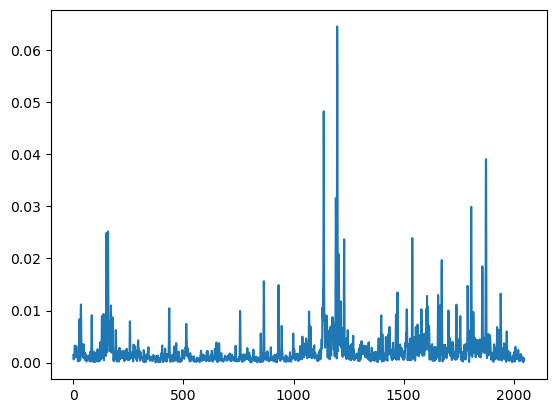

In [19]:
sns.lineplot(X_train[0][0][15])

In [20]:
X_train= X_train * wf

<Axes: >

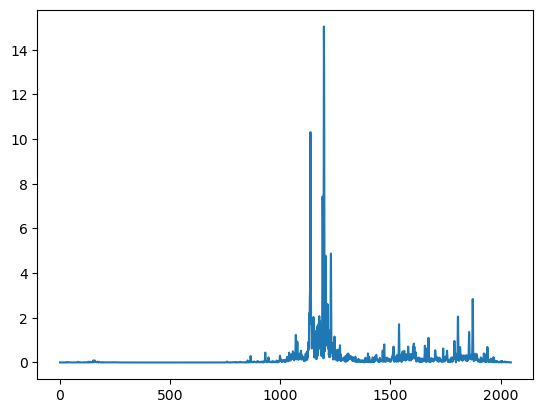

In [21]:
sns.lineplot(X_train[0][0][15])

In [11]:
X_dev = X_dev * wf

In [21]:
X_test = X_test * wf

In [22]:
dev_dataset = TensorDataset(X_dev, y_dev)
dataloader_dev = DataLoader(dev_dataset, batch_size=64, shuffle= True)

In [23]:
test_dataset = TensorDataset(X_test, y_test) 
dataloader_test = DataLoader(test_dataset, batch_size=64, shuffle = True)

In [24]:
y = np.array(dataloader_dev.dataset[:][1])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 클래스 가중치 계산
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
pos_weight = torch.tensor(class_weights[1]).to(device)
 
# 손실 함수 정의
learning_rate = 0.001
num_epochs = 10

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
# criterion = MyLoss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate )


In [31]:
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model.to(device)

# Initialize variables to keep track of the loss and predictions
total_loss = 0.0
all_labels = []
all_predictions = []
correct_cnt = 0
neg_pred_cnt = 0 

with torch.no_grad():
    for x_batch, labels in dataloader_dev:  # Assuming you have a separate validation or test DataLoader
        # Reshape x_batch to have one input channel
        # x_batch = x_batch.unsqueeze(1)  # Reshape: (batch_size, 1, 5000)
        x_batch = x_batch.to(device)  # Move x_batch to device
        
        # labels = labels.to(device)
        labels = labels.to(device).long() #DEV로 평가할 경우
        # print(x_batch.shape)
        outputs = model(x_batch)  # Forward pass
        # loss = criterion(outputs, labels.view(-1,1).float())  # Calculate loss
        
        # total_loss += loss.item()  # Accumulate the loss
        # Get predictions
        # _, predicted = torch.max(outputs, 1)  # Get the index of the max log-probability
        
        predicted = (torch.sigmoid(outputs) > 0.5 ).int()
        
        all_labels.extend(labels.cpu().numpy())  # Store true labels
        all_predictions.extend(predicted.cpu().numpy())  # Store predicted labels

# Calculate average loss
# avg_loss = total_loss / len(dataloader_dev)
print(len(all_labels), len(all_predictions))

# Calculate precision, recall, and F1 score
precision = precision_score(all_labels, all_predictions, average='weighted')  # Use 'micro' or 'macro' if needed
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')

cm = confusion_matrix(all_labels, all_predictions)

TN = cm[0, 0]  
FP = cm[0, 1] 
FN = cm[1, 0]  
TP = cm[1, 1]  

FPR = FP / (FP + TN) if (FP + TN) > 0 else 0  
FNR = FN / (FN + TP) if (FN + TP) > 0 else 0  

# Print results
# average_loss = total_loss / len(dataloader_dev)
# accuracy = correct / total
conf_matrix = confusion_matrix(all_labels, all_predictions)
 
TN = conf_matrix[0, 0]  
FP = conf_matrix[0, 1] 
FN = conf_matrix[1, 0]  
TP = conf_matrix[1, 1]  
Neg_precision = TN/(FN+TN)
Neg_recall =TN/(FP+TN)
 
for i in range(len(all_labels)) :
    if all_labels[i] == 0 and all_predictions[i] == 0:
        correct_cnt += 1
for pred in all_predictions:
    if pred == 0:
        neg_pred_cnt += 1
 
# print(f"Test Loss: {average_loss:.4f}, Accuracy: {accuracy:.4f},")
print(f'Neg_Precision: {Neg_precision:.4f} = {TN}/{FN + TN}, Neg_Recall: {Neg_recall:.4f} = {TN}/{FP + TN}, Neg_F1: {2*(Neg_precision * Neg_recall)/(Neg_precision + Neg_recall):.4f}') 
print(f'correct_cnt {correct_cnt}, neg_pred_cnt {neg_pred_cnt}')
print(all_predictions)

cuda
370 370
Neg_Precision: 1.0000 = 20/20, Neg_Recall: 0.6667 = 20/30, Neg_F1: 0.8000
correct_cnt 20, neg_pred_cnt 20
[array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([0]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([0]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), arra